# Determining the Terrorist Group Resposible for an Attack
As part of the application to Fellowship.AI I tackled the problem of determining determining the terrorist group resposible for an attack using information from the [Global Terrorism Database](https://www.start.umd.edu/gtd/) (GTD). On a first minimal effort attempt I was able to get 82% accuracy and after playing with the data and adjusting model parameters I was able to increase that to 85%. With more experience, CPU power, and perhaps incorporating metadata such as whether days of attacks correspond to holidays I am confident it is possible to make a model at least 90% accurate.

### Dependencies and Print Settings

In [1]:
import os
import csv
import random
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from fastai.imports import *
from fastai.structured import *

np.set_printoptions(threshold=np.nan)
pd.set_option('display.max_rows', None, 'display.max_columns', None)

### Import Data
The data was provided in .xlsx format and converting it to .csv led to encoding issues with UTF-8. Encoding latin1 or ISO-8895-1 work. The data is read and then the first 5 rows are printed below. We start with 135 columns and 181691 rows.

In [2]:
data = pd.read_csv('/Users/XXI/Downloads/globalterrorismdb_0718dist.csv', header=0, encoding='latin1', low_memory=False) # or 'ISO-8859-1'
display(data.head())
print(len(data)) # 135 columns

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.997490,23.762728,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN

181691


### Target Variable - Terrorist Groups
It's important to see what we're trying to find, so let's print the first 5 unique terrorist groups. In total there are 3537 unique terrorist groups including Unknown. Our score will be determined by our accuracy in finding the correct group resposible for an attack with circumstantial data.

In [3]:
print(data['gname'].unique()[:5])
print(len(data['gname'].unique()))

['MANO-D' '23rd of September Communist League' 'Unknown' 'Black Nationalists' 'Tupamaros (Uruguay)']
3537


### Feature Usage
I find it useful to look at feature usage - ratio of rows with data to total rows. This tells us that for some features every attack has a data point while for others only <3% do. My instinct was to eliminate some of the features/columns with sparse data, however the rare occurance of a certain feature may actually be a highly important signal that can identify a specific terrorist group. No columns were dropped, but this may be useful to look at again later.

In [4]:
features = list(data.columns)
feature_usage = np.zeros((len(data.columns)))

for i in range(0, len(data.columns)):
    feature_usage[i] = 1 - (data[features[i]].isnull().sum()/len(data))

feature = pd.DataFrame(np.zeros((1, len(data.columns))), columns=features)
feature.loc[0, :] = feature_usage
display(feature)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,1.0,1.0,1.0,1.0,0.05085,1.0,0.012219,1.0,1.0,1.0,1.0,0.997683,0.997611,0.974924,0.974919,0.999967,1.0,0.305436,0.636036,1.0,1.0,1.0,0.999994,0.159672,0.159672,0.999994,1.0,1.0,1.0,1.0,0.034751,0.034751,0.002356,0.002356,1.0,1.0,0.942909,0.942909,0.765811,0.9965,0.991419,0.991419,0.061335,0.061335,0.058809,0.058809,0.055682,0.060652,0.059596,0.059596,0.006473,0.006473,0.006038,0.006038,0.005647,0.006467,0.006313,0.006313,1.0,0.032418,0.011079,0.000881,0.001783,0.00011,0.27828,0.997909,0.01076,0.001761,1.0,0.608594,0.617543,0.636085,0.10503,0.10503,0.010402,0.00339,0.00339,0.00175,0.000732,0.000732,0.026633,1.0,1.0,0.885696,0.885696,0.072249,0.072249,0.063525,0.063525,0.010254,0.010254,0.009318,0.009318,0.000402,0.000402,0.000385,0.000385,0.627554,0.943239,0.645299,0.631473,0.910227,0.64389,0.619447,1.0,0.352604,0.352604,0.21459,0.318998,0.99902,0.074698,0.074396,0.022362,0.044713,0.001783,0.01819,0.425893,0.00743,0.003099,0.00426,0.003038,0.002829,0.060493,0.060493,0.05724,0.155698,0.635695,0.423428,0.239506,1.0,1.0,1.0,1.0,1.0,0.137805


### Converting Strings to Numbers
Random forests need everything to be numerical to do calculations and that is not currently the case with our data set that is full of strings. Fortunately, FastAI's library provides two incredibly useful functions to deal with this: train_cats and proc_df. Train_cats transforms string data into categorical data and make a dictionary behind the scenes corresponding each category to a number. Proc_df then applies this dictionary to the data while simultaneously removing the target variable and making it it's own variable.  

Below the weapon type categories are printed.

In [5]:
train_cats(data)
data['weaptype1_txt'].cat.categories

Index(['Biological', 'Chemical', 'Explosives', 'Fake Weapons', 'Firearms',
       'Incendiary', 'Melee', 'Other', 'Radiological', 'Sabotage Equipment',
       'Unknown',
       'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)'],
      dtype='object')

### Don't Cheat - Even By Accident
Using proc_df we create two new variables: num_data and terrorists, which is the feature labeled gname. A  third variable conversions simply stores the dictionary used to transform the categorical data to numbers.  

One might consider our data split now and ready to move on, but let's double check first. Scroll up and check the columns names above again. After gname there are several other columns for group subnames, secondary, and tertiary names. We need to remove these. If our target variable is Al-Qaeda and the subname or secondary name is available as AQ, Khorasan, or Khorasan Group we can simply link that to the target variable. Thus we would not be doing any ML, just using abreviations or street names to determine the parent organization, which would likely be a linear relationship if the data is available. Looking at the feature usage above it shows that the subnames are not well documented (<3%) so in theory this would not give a big edge, but nonetheless we should get rid of these columns.  

The other point to note is that some columns are repeats of others except with txt at the end. This means that a column, for example country_txt already has a numerical column country. We can drop the txt columns as they are redundant.  

The new data frame is printed below and all the values are numeric or booleans.

In [6]:
num_data, terrorists, conversions = proc_df(data, 'gname')
num_data = num_data.drop(columns=['gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3'])

columns = list(num_data.columns)
for i in columns:
    if(i[len(i)-3:len(i)] == 'txt'):
        num_data = num_data.drop(columns=[i])

display(num_data.head())

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,region,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,multiple,success,suicide,attacktype1,attacktype2,attacktype3,targtype1,targsubtype1,corp1,target1,natlty1,targtype2,targsubtype2,corp2,target2,natlty2,targtype3,targsubtype3,corp3,target3,natlty3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claim2,claimmode2,claim3,claimmode3,compclaim,weaptype1,weapsubtype1,weaptype2,weapsubtype2,weaptype3,weapsubtype3,weaptype4,weapsubtype4,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,latitude_na,longitude_na,specificity_na,doubtterr_na,alternative_na,multiple_na,attacktype2_na,attacktype3_na,targsubtype1_na,natlty1_na,targtype2_na,targsubtype2_na,natlty2_na,targtype3_na,targsubtype3_na,natlty3_na,guncertain1_na,guncertain2_na,guncertain3_na,nperps_na,nperpcap_na,claimed_na,claimmode_na,claim2_na,claimmode2_na,claim3_na,claimmode3_na,compclaim_na,weapsubtype1_na,weaptype2_na,weapsubtype2_na,weaptype3_na,weapsubtype3_na,weaptype4_na,weapsubtype4_na,nkill_na,nkillus_na,nkillter_na,nwound_na,nwoundus_na,nwoundte_na,propextent_na,propvalue_na,ishostkid_na,nhostkid_na,nhostkidus_na,nhours_na,ndays_na,ransom_na,ransomamt_na,ransomamtus_na,ransompaid_na,ransompaidus_na,hostkidoutcome_na,nreleased_na
0,197000000001,1970,7,2,0,0,0,58,2,0,29807,18.456792,-69.951164,1.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,1,2.0,7.0,14,68.0,0,40138,58.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,-99.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,13,12.0,6.0,7.0,6.0,7.0,6.0,9.5,0,1.0,0.0,0.0,0.0,0.0,0.0,0,3.0,-99.0,0,0.0,2.0,0.0,-99.0,-99.0,0,0,0.0,15000.0,0.0,0.0,0.0,0,4.0,0.0,0,0,0,0,14,0,0,0,0,0,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True
1,197000000002,1970,0,0,0,0,0,130,1,783,22167,19.371887,-99.086624,1.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,6,2.0,7.0,7,45.0,4295,48244,21.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,7.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,13,12.0,6.0,7.0,6.0,7.0,6.0,9.5,0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,-99.0,0,1.0,1.0,0.0,-99.0,-99.0,0,121,1.0,800000.0,0.0,0.0,0.0,0,4.0,0.0,0,0,0,0,14,0,1,1,1,0,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,False,False,True,True,False,False,True,True,True,True,True
2,197001000001,1970,1,0,0,0,0,160,5,2498,34518,15.478598,120.599741,4.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,1,2.0,7.0,10,54.0,31395,27325,217.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,-99.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,13,12.0,6.0,7.0,6.0,7.0,6.0,9.5,0,1.0,0.0,0.0,0.0,0.0,0.0,0,3.0,-99.0,0,0.0,2.0,0.0,-99.0,-99.0,0,0,0.0,15000.0,0.0,0.0,0.0,0,4.0,0.0,0,0,0,0,14,-9,-9,1,1,0,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True
3,197001000002,1970,1,0,0,0,0,78,8,185,2514,37.997490,23.762728,1.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,3,2.0,7.0,7,46.0,0,75372,217.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,-99.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,6,16.0,6.0,7.0,6.0,7.0,6.0,9.5,9852,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,-99.0,0,0.0,2.0,0.0,-99.0,-99.0,0,0,0.0

### Training and Validation Data
In machine learning it is vital to have two data sets, one for training and one for testing. This way we can evaluate our model based on it's outputs on data it has never seen before. I tend to use 80% of the data for training and 20% for validation. Now how to choose the 20% to pull out is not arbitrary. Sometimes it is ideal to do it at random, but here our data is in chronological order. Should a terrorist attack occur tomorrow and we want to determine who is responsible it would be better to look at the most recent data. For this reason the valiation set is the most recent 20% of the data.

In [7]:
valid_pts = int(len(num_data)*0.2)
X_train, X_valid = num_data.loc[0:len(num_data)-valid_pts-1, :], num_data.loc[(len(num_data)-valid_pts):, :]
Y_train, Y_valid = terrorists[0:len(num_data)-valid_pts], terrorists[(len(num_data)-valid_pts):]
display(X_train.head())
# print(Y_train[:5])

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,region,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,multiple,success,suicide,attacktype1,attacktype2,attacktype3,targtype1,targsubtype1,corp1,target1,natlty1,targtype2,targsubtype2,corp2,target2,natlty2,targtype3,targsubtype3,corp3,target3,natlty3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claim2,claimmode2,claim3,claimmode3,compclaim,weaptype1,weapsubtype1,weaptype2,weapsubtype2,weaptype3,weapsubtype3,weaptype4,weapsubtype4,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,latitude_na,longitude_na,specificity_na,doubtterr_na,alternative_na,multiple_na,attacktype2_na,attacktype3_na,targsubtype1_na,natlty1_na,targtype2_na,targsubtype2_na,natlty2_na,targtype3_na,targsubtype3_na,natlty3_na,guncertain1_na,guncertain2_na,guncertain3_na,nperps_na,nperpcap_na,claimed_na,claimmode_na,claim2_na,claimmode2_na,claim3_na,claimmode3_na,compclaim_na,weapsubtype1_na,weaptype2_na,weapsubtype2_na,weaptype3_na,weapsubtype3_na,weaptype4_na,weapsubtype4_na,nkill_na,nkillus_na,nkillter_na,nwound_na,nwoundus_na,nwoundte_na,propextent_na,propvalue_na,ishostkid_na,nhostkid_na,nhostkidus_na,nhours_na,ndays_na,ransom_na,ransomamt_na,ransomamtus_na,ransompaid_na,ransompaidus_na,hostkidoutcome_na,nreleased_na
0,197000000001,1970,7,2,0,0,0,58,2,0,29807,18.456792,-69.951164,1.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,1,2.0,7.0,14,68.0,0,40138,58.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,-99.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,13,12.0,6.0,7.0,6.0,7.0,6.0,9.5,0,1.0,0.0,0.0,0.0,0.0,0.0,0,3.0,-99.0,0,0.0,2.0,0.0,-99.0,-99.0,0,0,0.0,15000.0,0.0,0.0,0.0,0,4.0,0.0,0,0,0,0,14,0,0,0,0,0,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True
1,197000000002,1970,0,0,0,0,0,130,1,783,22167,19.371887,-99.086624,1.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,6,2.0,7.0,7,45.0,4295,48244,21.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,7.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,13,12.0,6.0,7.0,6.0,7.0,6.0,9.5,0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,-99.0,0,1.0,1.0,0.0,-99.0,-99.0,0,121,1.0,800000.0,0.0,0.0,0.0,0,4.0,0.0,0,0,0,0,14,0,1,1,1,0,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,False,False,True,True,False,False,True,True,True,True,True
2,197001000001,1970,1,0,0,0,0,160,5,2498,34518,15.478598,120.599741,4.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,1,2.0,7.0,10,54.0,31395,27325,217.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,-99.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,13,12.0,6.0,7.0,6.0,7.0,6.0,9.5,0,1.0,0.0,0.0,0.0,0.0,0.0,0,3.0,-99.0,0,0.0,2.0,0.0,-99.0,-99.0,0,0,0.0,15000.0,0.0,0.0,0.0,0,4.0,0.0,0,0,0,0,14,-9,-9,1,1,0,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True
3,197001000002,1970,1,0,0,0,0,78,8,185,2514,37.997490,23.762728,1.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,3,2.0,7.0,7,46.0,0,75372,217.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,-99.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,6,16.0,6.0,7.0,6.0,7.0,6.0,9.5,9852,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,-99.0,0,0.0,2.0,0.0,-99.0,-99.0,0,0,0.0

### Base Model and Evaluation
For kicks let's run the Random Forest now. Since we are predicting categories and not numbers we will use a classifier instead of a regressor. We won't change any settings, expept telling it to use all the cores available to the CPUs.  

After about 5 minuts of run time we find that without doing anything intelligent we are 99% accurate on the in sample data and over 82% accurate on the out of sample data.  

This will be our baseline and now we'll see what we can do to improve this. It might also be interesting to look at the r^2 values as those indicate how much better our model is than predicting the mean. However, our data is a category. If the answer is 10 and one responds 9 they are objectively not far off. But what if the answer is Hamas and our model selects ISIS? How far off are we? Since these will be converted to numbers we can still calculate RMSE and r^2, but their values will not yield anything meaningful. Therefore we will only be using percent accuracy to determine the quality of our model.

In [8]:
model = RandomForestClassifier(n_jobs=-1)
%time model.fit(X_train, Y_train)
%time in_sample = model.score(X_train, Y_train)
%time out_sample = model.score(X_valid, Y_valid)
print([in_sample, out_sample])

/Users/XXI/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 41s, sys: 15.3 s, total: 1min 56s
Wall time: 40.5 s
CPU times: user 2min, sys: 3min 25s, total: 5min 25s
Wall time: 3min 8s
CPU times: user 14 s, sys: 8.58 s, total: 22.6 s
Wall time: 8.69 s
[0.9964225024595296, 0.8234080026418625]


### Interactive Analysis
Apparently many scientists and analysts are always modeling all the data they have. Why not? It's available, more data yields greater insights, computers are powerful enough, etc. But even using all the CPUs and tricked out servers on AWS some models will take time, whether that be 5 minutes or 5 hours does not matter.  

The point is that any model that takes more than 1 second to run is too slow to be productive. Jeremy Howard, the founder of FastAi, advocates interactive analysis: run the model, analyze, tweak it, repeat. If you're running a model and you have time to go make a cup of tea before it finishes you're wrecking your work flow. As someone who used to do the former I now strongly believe in the latter.  That is why in the next cells I take only 10k data points (again the most recent ones because it's a time series) to model. With 10k training points and 2k validation points every simulation takes less than a second. As seen below the out of sample score drops significantly, but this doesn't matter. Now we can test and tweak faster and if it improves this bad, small size model it will yield an improvement on our full model, which we can wait until the end to run.

In [9]:
small_train = 10000
small_valid = int(small_train*0.2)
Xs_train, Xs_valid = num_data.loc[len(num_data)-small_train-small_valid+1:len(num_data)-small_valid, :], num_data.loc[(len(num_data)-small_valid):, :]
Ys_train, Ys_valid = terrorists[len(num_data)-small_train-small_valid:len(num_data)-small_valid], terrorists[(len(num_data)-small_valid):]

model = RandomForestClassifier(n_jobs=-1)
%time model.fit(Xs_train, Ys_train)
%time in_sample = model.score(Xs_train, Ys_train)
%time out_sample = model.score(Xs_valid, Ys_valid)
print([in_sample, out_sample])

/Users/XXI/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1.61 s, sys: 372 ms, total: 1.99 s
Wall time: 1.14 s
CPU times: user 587 ms, sys: 224 ms, total: 811 ms
Wall time: 471 ms
CPU times: user 116 ms, sys: 36.9 ms, total: 153 ms
Wall time: 177 ms
[0.9829, 0.3955]


### Playing with Hyperparameters
By default sklearn's forests use 10 trees or estimators. The most basic thing we can do to improve results is increase it to 100. Let's also get an out of bag score (oob), which tells us our score using samples from the training set which were not used. Here our oob score is low, but our out of validation set score has increased. Normally increasing the number of trees leads to an improved model up to a certain point where it plateaus.

In [10]:
model = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
model.fit(Xs_train, Ys_train)
in_sample = model.score(Xs_train, Ys_train)
out_sample = model.score(Xs_valid, Ys_valid)
print([in_sample, out_sample, model.oob_score_])

[0.9966, 0.501, 0.424]


Next let's set the mininum number of samples per leade node to 3. This might control for overfitting as otherwise every result will get it's own leaf node.

In [11]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, oob_score=True, n_jobs=-1)
model.fit(Xs_train, Ys_train)
in_sample = model.score(Xs_train, Ys_train)
out_sample = model.score(Xs_valid, Ys_valid)
print([in_sample, out_sample, model.oob_score_])

[0.657, 0.4985, 0.4476]


What if we turn bootstrapping off? This means that instead of selecting features randomly, we always select what's best. This makes the model worse. However it's not surpring. A random forest is just an agglomeration of decision trees. If each tree is modeled to perfection the value of each additional tree is negligible as they're likely all very similar.  

Consider a classic interview question such as predicting how many golf balls fit in an airplane. We can model it using the dimensions of the objects and hexagonal close packing like atoms. Or we could ask 1000 people and avaerage their guesses. The second, seemingly stupid, method works because in a normal distribution the people who make extremely high or low guesses will cancel each other out and most peole will try to guess correctly getting you shockingly close to the correct answer.

In [12]:
model = RandomForestClassifier(n_estimators=100, bootstrap=False, n_jobs=-1)
model.fit(Xs_train, Ys_train)
in_sample = model.score(Xs_train, Ys_train)
out_sample = model.score(Xs_valid, Ys_valid)
print([in_sample, out_sample])

[0.9966, 0.492]


With the random forest we are doing the latter, with each tree equivalent to the person taking a random guess. The advantage of the random forest is the random aspect. If each tree models things using different features and splits the errors of each individual tree cancel and the mean of the tree's predictions gets us relatively close to the truth.  

With this in mind is is better to have a lot of trees each modeled differently even if it means each tree is individually a worse estimator. To accomplish this we can set max features to 0.5 which means that for each split the model only looks at half of the features.

In [13]:
model = RandomForestClassifier(n_estimators=100, max_features=0.5, oob_score=True, n_jobs=-1)
model.fit(Xs_train, Ys_train)
in_sample = model.score(Xs_train, Ys_train)
out_sample = model.score(Xs_valid, Ys_valid)
print([in_sample, out_sample, model.oob_score_])

[0.9966, 0.499, 0.419]


### Feature Analysis
I know I stressed doing small/fast tests, but for feature engineering it would be better to use the full model for certain aspects so we'll run the full model without any parameters again.

In [14]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, Y_train)
in_sample = model.score(X_train, Y_train)
out_sample = model.score(X_valid, Y_valid)
print([in_sample, out_sample])

/Users/XXI/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.9966288965484028, 0.8236281578512852]


### Feature Importance
We can now find which features are more important to our model. Doing this on the small models would give somewhat different results each time due to the small data set used, which is why I opted to run the full model before checking this.

            cols       imp
97      INT_IDEO  0.095134
99       INT_ANY  0.090963
7        country  0.065969
11      latitude  0.061796
12     longitude  0.060083
96       INT_LOG  0.056344
32       natlty1  0.052239
0        eventid  0.040235
8         region  0.037454
1          iyear  0.030209
9      provstate  0.025755
44   guncertain1  0.018988
31       target1  0.018446
10          city  0.017128
29  targsubtype1  0.017125


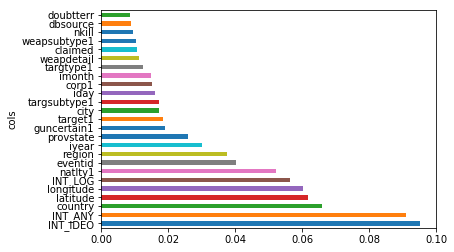

In [15]:
feat_imp = rf_feat_importance(model, X_train)
print(feat_imp[:15])
feat_imp[:25].plot('cols','imp','barh', legend=False);

The above data still varies from run to run, but more evident trends begin to emerge. INT_LOG, INT_IDEO, and INT_ANY seem to be some of the most important features along with longitude and latitude. The first 3 features are rather strange as even in the original data set they are just integers, which don't have any corresponding text columns. INT_IDEO I can only presume is an integer corresponding to the groups ideology, but the other two are a mystery.  

Latitude and longitude make sense as it's just the precise location of the attack, which we would expect to be correlated with the group responsible. For these reasons nationality, country, and region also appear. Another key factor is eventid, which might as well be a timestamp.  

With this is mind one of the first things we can try doing is creating a new subset of data with only most important 50% of the columns.

In [16]:
most_imp_feats = feat_imp[:int(0.5*len(num_data.columns))]
most_imp_feats = list(most_imp_feats['cols'])
best_feat_data = num_data[most_imp_feats]

Xf_train, Xf_valid = num_data.loc[len(num_data)-small_train-small_valid+1:len(num_data)-small_valid, :], num_data.loc[(len(num_data)-small_valid):, :]

Using this new subset of data only including half of the most valuable columns we can run the model again to see if it affects our accuracy. It helps a tiny bit (relative to scores on the small data set), but more interestingly we see that it uses different columns for splitting and there isn't as big of a difference between each columns' importance.

[0.9966, 0.501, 0.4189]


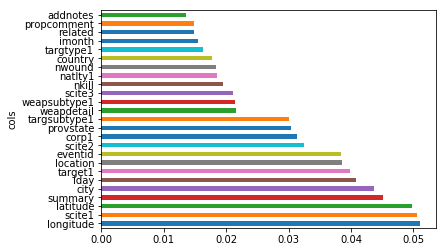

In [17]:
model = RandomForestClassifier(n_estimators=100, max_features=0.5, oob_score=True, n_jobs=-1)
model.fit(Xf_train, Ys_train)
in_sample = model.score(Xf_train, Ys_train)
out_sample = model.score(Xf_valid, Ys_valid)
print([in_sample, out_sample, model.oob_score_])

feat_imp1 = rf_feat_importance(model, Xf_train)
feat_imp1[:25].plot('cols','imp','barh', legend=False);

### One Hot Encoding
Of the most important features we now want to take a closer look. We can begin by checking how many unique items are in each column. For columns that contain a relatiely small number of unrelated unique items it my aid to one hot encode them, which creates a new column with only binary values for each unique item previously in the selected column.  

The data frame below shows how many unique items are in each of the most important columns.

In [18]:
feats = list(feat_imp.loc[:25, 'cols'])

feat_unique = []
for i in feats:
    feat_unique.append(int(len(num_data[i].unique())))

feat_uniques = pd.DataFrame(np.zeros((1, len(feats))), columns=feats)
feat_uniques.loc[0, :] = feat_unique
display(feat_uniques)

,INT_IDEO,INT_ANY,country,latitude,longitude,INT_LOG,natlty1,eventid,region,iyear,provstate,guncertain1,target1,city,targsubtype1,iday,corp1,imonth,targtype1,weapdetail,claimed,weapsubtype1,nkill,dbsource,doubtterr,scite1,attacktype1
0,3.0,3.0,205.0,48322.0,48039.0,3.0,215.0,181691.0,12.0,47.0,2856.0,2.0,86007.0,36675.0,112.0,32.0,33239.0,13.0,22.0,19149.0,3.0,30.0,205.0,26.0,3.0,83989.0,9.0


The INT_ columns only contain values of 0, 1, and -9. In the case of INT_IDEO which likely corresponds to a groups ideology there is little reason to put them together. Comparing 0 to 1 and -9 might translate to Christianity compared to Judaism and Islam, which doesn't make sense so we can one hot encode these columns. Since they all use the same values we'll first replace the numbers with new ones as to avoid column name overlaps later.  

Since we'll be heavily editing the dataframe now, we'll create a new one for encoding so we can screw it up and not have ruined or the dataframe we've been working with up until now.

In [19]:
oh_data = num_data.copy()

oh_data.loc[:, 'INT_LOG'] = oh_data.loc[:, 'INT_LOG'].replace(1, 2)
oh_data.loc[:, 'INT_LOG'] = oh_data.loc[:, 'INT_LOG'].replace(0, 1)
oh_data.loc[:, 'INT_LOG'] = oh_data.loc[:, 'INT_LOG'].replace(-9, 3)

oh_data.loc[:, 'INT_IDEO'] = oh_data.loc[:, 'INT_IDEO'].replace(0, 4)
oh_data.loc[:, 'INT_IDEO'] = oh_data.loc[:, 'INT_IDEO'].replace(1, 5)
oh_data.loc[:, 'INT_IDEO'] = oh_data.loc[:, 'INT_IDEO'].replace(-9, 6)

oh_data.loc[:, 'INT_ANY'] = oh_data.loc[:, 'INT_ANY'].replace(0, 7)
oh_data.loc[:, 'INT_ANY'] = oh_data.loc[:, 'INT_ANY'].replace(1, 8)
oh_data.loc[:, 'INT_ANY'] = oh_data.loc[:, 'INT_ANY'].replace(-9, 9)
        
display(oh_data.head())

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,region,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,multiple,success,suicide,attacktype1,attacktype2,attacktype3,targtype1,targsubtype1,corp1,target1,natlty1,targtype2,targsubtype2,corp2,target2,natlty2,targtype3,targsubtype3,corp3,target3,natlty3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claim2,claimmode2,claim3,claimmode3,compclaim,weaptype1,weapsubtype1,weaptype2,weapsubtype2,weaptype3,weapsubtype3,weaptype4,weapsubtype4,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,latitude_na,longitude_na,specificity_na,doubtterr_na,alternative_na,multiple_na,attacktype2_na,attacktype3_na,targsubtype1_na,natlty1_na,targtype2_na,targsubtype2_na,natlty2_na,targtype3_na,targsubtype3_na,natlty3_na,guncertain1_na,guncertain2_na,guncertain3_na,nperps_na,nperpcap_na,claimed_na,claimmode_na,claim2_na,claimmode2_na,claim3_na,claimmode3_na,compclaim_na,weapsubtype1_na,weaptype2_na,weapsubtype2_na,weaptype3_na,weapsubtype3_na,weaptype4_na,weapsubtype4_na,nkill_na,nkillus_na,nkillter_na,nwound_na,nwoundus_na,nwoundte_na,propextent_na,propvalue_na,ishostkid_na,nhostkid_na,nhostkidus_na,nhours_na,ndays_na,ransom_na,ransomamt_na,ransomamtus_na,ransompaid_na,ransompaidus_na,hostkidoutcome_na,nreleased_na
0,197000000001,1970,7,2,0,0,0,58,2,0,29807,18.456792,-69.951164,1.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,1,2.0,7.0,14,68.0,0,40138,58.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,-99.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,13,12.0,6.0,7.0,6.0,7.0,6.0,9.5,0,1.0,0.0,0.0,0.0,0.0,0.0,0,3.0,-99.0,0,0.0,2.0,0.0,-99.0,-99.0,0,0,0.0,15000.0,0.0,0.0,0.0,0,4.0,0.0,0,0,0,0,14,1,4,0,7,0,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True
1,197000000002,1970,0,0,0,0,0,130,1,783,22167,19.371887,-99.086624,1.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,6,2.0,7.0,7,45.0,4295,48244,21.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,7.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,13,12.0,6.0,7.0,6.0,7.0,6.0,9.5,0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,-99.0,0,1.0,1.0,0.0,-99.0,-99.0,0,121,1.0,800000.0,0.0,0.0,0.0,0,4.0,0.0,0,0,0,0,14,1,5,1,8,0,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,False,False,True,True,False,False,True,True,True,True,True
2,197001000001,1970,1,0,0,0,0,160,5,2498,34518,15.478598,120.599741,4.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,1,2.0,7.0,10,54.0,31395,27325,217.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,-99.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,13,12.0,6.0,7.0,6.0,7.0,6.0,9.5,0,1.0,0.0,0.0,0.0,0.0,0.0,0,3.0,-99.0,0,0.0,2.0,0.0,-99.0,-99.0,0,0,0.0,15000.0,0.0,0.0,0.0,0,4.0,0.0,0,0,0,0,14,3,6,1,8,0,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True
3,197001000002,1970,1,0,0,0,0,78,8,185,2514,37.997490,23.762728,1.0,0,0,0,1,1,1,0.0,1.0,0.0,1,0,3,2.0,7.0,7,46.0,0,75372,217.0,14.0,67.0,0,0,98.0,14.0,67.0,0,0,110.0,0,0.0,0.0,0.0,0,-99.0,0.0,0.0,8.0,0.0,7.0,0.0,7.0,-9.0,6,16.0,6.0,7.0,6.0,7.0,6.0,9.5,9852,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,-99.0,0,0.0,2.0,0.0,-99.0,-99.0,0,0,0.0,1

In addition, it makes sense to one hot encode the country, natlty1, and region columns. They have a reasonable number of unique values to convert to columns and it is a logical way to re-order the data. The previous conversions from string to categorical to numerical data go by order of appearance. Therefore if in the country column the first country is Uruguay and the second is USA these become 1 and 2. As this continues the numerical comparisons the tree makes become less valuable. If the countries in the Americas were numbered 1-5, Europe 6-20, Asia 20-30 there might be some logic to the scheme but right now there isn't. Additionally with almost 500 unique values it would be tedious to organize manually. The country column refers to the country where the attack occurs while the natlty1 column refers to the nationality of the attack target individual or group. Since these will over lap the encoding is tweaked to relabel country names with either occur_ or target_nat_ in front of the country name to avoid column name collisions.

In [20]:
onehot = pd.get_dummies(oh_data['INT_LOG'])
oh_data = oh_data.join(onehot)
oh_data = oh_data.drop(columns=['INT_LOG'])

onehot = pd.get_dummies(oh_data['INT_IDEO'])
oh_data = oh_data.join(onehot)
oh_data = oh_data.drop(columns=['INT_IDEO'])

onehot = pd.get_dummies(oh_data['INT_ANY'])
oh_data = oh_data.join(onehot)
oh_data = oh_data.drop(columns=['INT_ANY'])

onehot = pd.get_dummies(data['country_txt'])
for i in list(onehot.columns):
    new_name = 'occur_{}'.format(i)
    onehot = onehot.rename(columns={i:new_name})
oh_data = oh_data.join(onehot)
oh_data = oh_data.drop(columns=['country'])

onehot = pd.get_dummies(data['natlty1_txt'])
for i in list(onehot.columns):
    new_name = 'target_nat_{}'.format(i)
    onehot = onehot.rename(columns={i:new_name})
oh_data = oh_data.join(onehot)
oh_data = oh_data.drop(columns=['natlty1'])

onehot = pd.get_dummies(data['region_txt'])
oh_data = oh_data.join(onehot)
oh_data = oh_data.drop(columns=['region'])

display(oh_data.head())

,eventid,iyear,imonth,iday,approxdate,extended,resolution,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,multiple,success,suicide,attacktype1,attacktype2,attacktype3,targtype1,targsubtype1,corp1,target1,targtype2,targsubtype2,corp2,target2,natlty2,targtype3,targsubtype3,corp3,target3,natlty3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claim2,claimmode2,claim3,claimmode3,compclaim,weaptype1,weapsubtype1,weaptype2,weapsubtype2,weaptype3,weapsubtype3,weaptype4,weapsubtype4,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_MISC,related,latitude_na,longitude_na,specificity_na,doubtterr_na,alternative_na,multiple_na,attacktype2_na,attacktype3_na,targsubtype1_na,natlty1_na,targtype2_na,targsubtype2_na,natlty2_na,targtype3_na,targsubtype3_na,natlty3_na,guncertain1_na,guncertain2_na,guncertain3_na,nperps_na,nperpcap_na,claimed_na,claimmode_na,claim2_na,claimmode2_na,claim3_na,claimmode3_na,compclaim_na,weapsubtype1_na,weaptype2_na,weapsubtype2_na,weaptype3_na,weapsubtype3_na,weaptype4_na,weapsubtype4_na,nkill_na,nkillus_na,nkillter_na,nwound_na,nwoundus_na,nwoundte_na,propextent_na,propvalue_na,ishostkid_na,nhostkid_na,nhostkidus_na,nhours_na,ndays_na,ransom_na,ransomamt_na,ransomamtus_na,ransompaid_na,ransompaidus_na,hostkidoutcome_na,nreleased_na,1,2,3,4,5,6,7,8,9,occur_Afghanistan,occur_Albania,occur_Algeria,occur_Andorra,occur_Angola,occur_Antigua and Barbuda,occur_Argentina,occur_Armenia,occur_Australia,occur_Austria,occur_Azerbaijan,occur_Bahamas,occur_Bahrain,occur_Bangladesh,occur_Barbados,occur_Belarus,occur_Belgium,occur_Belize,occur_Benin,occur_Bhutan,occur_Bolivia,occur_Bosnia-Herzegovina,occur_Botswana,occur_Brazil,occur_Brunei,occur_Bulgaria,occur_Burkina Faso,occur_Burundi,occur_Cambodia,occur_Cameroon,occur_Canada,occur_Central African Republic,occur_Chad,occur_Chile,occur_China,occur_Colombia,occur_Comoros,occur_Costa Rica,occur_Croatia,occur_Cuba,occur_Cyprus,occur_Czech Republic,occur_Czechoslovakia,occur_Democratic Republic of the Congo,occur_Denmark,occur_Djibouti,occur_Dominica,occur_Dominican Republic,occur_East Germany (GDR),occur_East Timor,occur_Ecuador,occur_Egypt,occur_El Salvador,occur_Equatorial Guinea,occur_Eritrea,occur_Estonia,occur_Ethiopia,occur_Falkland Islands,occur_Fiji,occur_Finland,occur_France,occur_French Guiana,occur_French Polynesia,occur_Gabon,occur_Gambia,occur_Georgia,occur_Germany,occur_Ghana,occur_Greece,occur_Grenada,occur_Guadeloupe,occur_Guatemala,occur_Guinea,occur_Guinea-Bissau,occur_Guyana,occur_Haiti,occur_Honduras,occur_Hong Kong,occur_Hungary,occur_Iceland,occur_India,occur_Indonesia,occur_International,occur_Iran,occur_Iraq,occur_Ireland,occur_Israel,occur_Italy,occur_Ivory Coast,occur_Jamaica,occur_Japan,occur_Jordan,occur_Kazakhstan,occur_Kenya,occur_Kosovo,occur_Kuwait,occur_Kyrgyzstan,occur_Laos,occur_Latvia,occur_Lebanon,occur_Lesotho,occur_Liberia,occur_Libya,occur_Lithuania,occur_Luxembourg,occur_Macau,occur_Macedonia,occur_Madagascar,occur_Malawi,occur_Malaysia,occur_Maldives,occur_Mali,occur_Malta,occur_Martinique,occur_Mauritania,occur_Mauritius,occur_Mexico,occur_Moldova,occur_Montenegro,occur_Morocco,occur_Mozambique,occur_Myanmar,occur_Namibia,occur_Nepal,occur_Netherlands,occur_New Caledonia,occur_New Hebrides,occur_New Zealand,occur_Nicaragua,occur_Niger,occur_Nigeria,occur_North Korea,occur_North Yemen,occur_Norway,occur_Pakistan,occur_Panama,occur_Papua New Guinea,occur_Paraguay,occur_People's Republic of the Congo,occur_Peru,occur_Philippines,occur_Poland,occur_Portugal,occur_Qatar,occur_Republic of the Congo,occur_Rhodesia,occur_Romania,occur_Russia,occur_Rwanda,occur_Saudi Arabia,occur_Senegal,occur_Serbia,oc

Once again we'll take a small subset of the one hot encoded data to use for testing.

In [21]:
Xs_oh_train, Xs_oh_valid = oh_data.loc[len(oh_data)-small_train-small_valid+1:len(oh_data)-small_valid, :], oh_data.loc[(len(oh_data)-small_valid):, :]

We can also do this with a subset of all the data based on the most important features.

In [22]:
columns = ['INT_LOG', 'INT_IDEO', 'INT_ANY', 'country', 'natlty1', 'region']
most_imp_feats_oh = most_imp_feats.copy()
for i in columns:
    for j in range(0, len(most_imp_feats_oh)):
        if(i == most_imp_feats_oh[j]):
            most_imp_feats_oh.pop(j)
            break

Xf_oh_train, Xf_oh_valid = Xs_oh_train[most_imp_feats_oh], Xs_oh_valid[most_imp_feats_oh]

added = Xf_oh_train.iloc[:, 150:]
Xf_oh_train.join(added)

added = Xf_oh_valid.iloc[:, 150:]
Xf_oh_valid.join(added)

display(Xf_oh_train.head())

,latitude,longitude,eventid,iyear,provstate,guncertain1,target1,city,targsubtype1,iday,corp1,imonth,targtype1,weapdetail,claimed,weapsubtype1,nkill,dbsource,doubtterr,scite1,attacktype1,weaptype1,related,summary,nwound,scite2,INT_MISC,nperps,motive,specificity,location,propcomment,property,nperpcap_na,ransom_na,scite3,multiple,nwoundus_na,addnotes,propextent_na,nperps_na,claimed_na,propvalue,claimmode,nkillter_na,claimmode_na,propextent,propvalue_na,weapsubtype1_na,nwound_na,alternative_na,nkill_na,success,weapsubtype2,nhostkid,crit3,vicinity,nkillus_na,weaptype2,weapsubtype2_na,weaptype2_na,targsubtype1_na,nperpcap,natlty2,compclaim_na,target2,nkillter,nwoundte_na,nhostkid_na,nhostkidus_na,ishostkid,kidhijcountry
169692,23.459658,97.936234,201611250040,2016,2286,0.0,72923,18457,75.0,25,17187,11,14,17431,0.0,11.0,0.0,15,0.0,14846,3,6,0,100180,0.0,6356,0,-99.0,0,1.0,0,0,-9,False,True,0,0.0,False,0,True,False,False,-99.0,8.0,False,True,3.0,True,False,False,True,False,1,7.0,2.0,1,0,False,6.0,True,True,False,0.0,98.0,True,0,0.0,False,True,True,0.0,0
169693,54.819164,-7.467909,201611250041,2016,1823,0.0,52044,31882,79.0,25,27604,11,14,18075,0.0,31.0,0.0,15,0.0,54823,3,6,0,100188,0.0,27741,1,-99.0,0,1.0,36948,0,0,False,True,23724,0.0,False,0,True,False,False,-99.0,8.0,False,True,3.0,True,False,False,True,False,0,7.0,2.0,1,0,False,6.0,True,True,False,0.0,98.0,True,0,0.0,False,True,True,0.0,0
169694,11.291012,23.191802,201611250042,2016,488,0.0,77228,23044,18.0,25,11921,11,2,0,0.0,5.0,0.0,15,0.0,48078,1,5,0,100173,0.0,0,0,-99.0,9716,2.0,0,3853,1,False,True,0,0.0,False,0,False,False,False,-99.0,8.0,False,True,3.0,False,False,False,True,False,0,7.0,2.0,1,0,False,6.0,True,True,False,0.0,98.0,True,0,0.0,False,True,True,0.0,0
169695,13.586484,44.024105,201611250044,2016,2477,0.0,59506,32424,75.0,25,31005,11,14,8502,0.0,11.0,2.0,15,0.0,20442,3,6,0,100181,0.0,0,0,-99.0,0,1.0,0,10827,1,False,True,0,0.0,False,0,False,False,False,-99.0,8.0,False,True,3.0,False,False,False,True,False,1,7.0,2.0,1,0,False,6.0,True,True,False,0.0,98.0,True,0,0.0,False,True,True,0.0,0
169696,31.794243,35.037788,201611250045,2016,1089,1.0,35373,4438,76.0,25,21658,11,14,0,0.0,18.0,0.0,15,0.0,29501,7,8,13556,100175,0.0,20619,0,2.0,0,1.0,0,18649,1,False,True,12807,1.0,False,13684,False,False,False,-99.0,8.0,False,True,4.0,False,False,False,True,False,1,7.0,2.0,1,0,False,6.0,True,True,False,2.0,98.0,True,0,0.0,False,True,True,0.0,0


### Same Model, "New" Data
Now we can can run the model again with the subset of one hot encoded data and the subset of one hot encoded data limited to the most important columns (50% of total). The model using all the columns appears to do slightly better.

In [23]:
model = RandomForestClassifier(n_estimators=100, max_features='sqrt', oob_score=True, n_jobs=-1)
model.fit(Xs_oh_train, Ys_train)
in_sample = model.score(Xs_oh_train, Ys_train)
out_sample = model.score(Xs_oh_valid, Ys_valid)
print([in_sample, out_sample, model.oob_score_])

model = RandomForestClassifier(n_estimators=100, max_features='sqrt', oob_score=True, n_jobs=-1)
model.fit(Xf_oh_train, Ys_train)
in_sample = model.score(Xf_oh_train, Ys_train)
out_sample = model.score(Xf_oh_valid, Ys_valid)
print([in_sample, out_sample, model.oob_score_])

[0.9966, 0.511, 0.4189]
[0.9965, 0.472, 0.4209]


### Dropping NaN Columns
In reviewing the data it seems that when converting strings to numbers some extra columns were made specifically for NaNs. These columns are renamed after the name of the column where the NaN was found with \_na at the end. They only contain boolean values and never show up as an important feature, so we can delete them to see if that improves the model. We'll do this for training and validation data of both all columns and the most important columns.

In [24]:
for i in list(Xs_oh_train.columns):
    i = str(i)
    if(i[len(i)-3:len(i)] == '_na'):
        Xs_oh_train = Xs_oh_train.drop(columns=[i])

for i in list(Xs_oh_valid.columns):
    i = str(i)
    if(i[len(i)-3:len(i)] == '_na'):
        Xs_oh_valid = Xs_oh_valid.drop(columns=[i])

for i in list(Xf_oh_train.columns):
    i = str(i)
    if(i[len(i)-3:len(i)] == '_na'):
        Xf_oh_train = Xf_oh_train.drop(columns=[i])

for i in list(Xf_oh_valid.columns):
    i = str(i)
    if(i[len(i)-3:len(i)] == '_na'):
        Xf_oh_valid = Xf_oh_valid.drop(columns=[i])
        
display(Xs_oh_train.head())

,eventid,iyear,imonth,iday,approxdate,extended,resolution,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,multiple,success,suicide,attacktype1,attacktype2,attacktype3,targtype1,targsubtype1,corp1,target1,targtype2,targsubtype2,corp2,target2,natlty2,targtype3,targsubtype3,corp3,target3,natlty3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claim2,claimmode2,claim3,claimmode3,compclaim,weaptype1,weapsubtype1,weaptype2,weapsubtype2,weaptype3,weapsubtype3,weaptype4,weapsubtype4,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_MISC,related,1,2,3,4,5,6,7,8,9,occur_Afghanistan,occur_Albania,occur_Algeria,occur_Andorra,occur_Angola,occur_Antigua and Barbuda,occur_Argentina,occur_Armenia,occur_Australia,occur_Austria,occur_Azerbaijan,occur_Bahamas,occur_Bahrain,occur_Bangladesh,occur_Barbados,occur_Belarus,occur_Belgium,occur_Belize,occur_Benin,occur_Bhutan,occur_Bolivia,occur_Bosnia-Herzegovina,occur_Botswana,occur_Brazil,occur_Brunei,occur_Bulgaria,occur_Burkina Faso,occur_Burundi,occur_Cambodia,occur_Cameroon,occur_Canada,occur_Central African Republic,occur_Chad,occur_Chile,occur_China,occur_Colombia,occur_Comoros,occur_Costa Rica,occur_Croatia,occur_Cuba,occur_Cyprus,occur_Czech Republic,occur_Czechoslovakia,occur_Democratic Republic of the Congo,occur_Denmark,occur_Djibouti,occur_Dominica,occur_Dominican Republic,occur_East Germany (GDR),occur_East Timor,occur_Ecuador,occur_Egypt,occur_El Salvador,occur_Equatorial Guinea,occur_Eritrea,occur_Estonia,occur_Ethiopia,occur_Falkland Islands,occur_Fiji,occur_Finland,occur_France,occur_French Guiana,occur_French Polynesia,occur_Gabon,occur_Gambia,occur_Georgia,occur_Germany,occur_Ghana,occur_Greece,occur_Grenada,occur_Guadeloupe,occur_Guatemala,occur_Guinea,occur_Guinea-Bissau,occur_Guyana,occur_Haiti,occur_Honduras,occur_Hong Kong,occur_Hungary,occur_Iceland,occur_India,occur_Indonesia,occur_International,occur_Iran,occur_Iraq,occur_Ireland,occur_Israel,occur_Italy,occur_Ivory Coast,occur_Jamaica,occur_Japan,occur_Jordan,occur_Kazakhstan,occur_Kenya,occur_Kosovo,occur_Kuwait,occur_Kyrgyzstan,occur_Laos,occur_Latvia,occur_Lebanon,occur_Lesotho,occur_Liberia,occur_Libya,occur_Lithuania,occur_Luxembourg,occur_Macau,occur_Macedonia,occur_Madagascar,occur_Malawi,occur_Malaysia,occur_Maldives,occur_Mali,occur_Malta,occur_Martinique,occur_Mauritania,occur_Mauritius,occur_Mexico,occur_Moldova,occur_Montenegro,occur_Morocco,occur_Mozambique,occur_Myanmar,occur_Namibia,occur_Nepal,occur_Netherlands,occur_New Caledonia,occur_New Hebrides,occur_New Zealand,occur_Nicaragua,occur_Niger,occur_Nigeria,occur_North Korea,occur_North Yemen,occur_Norway,occur_Pakistan,occur_Panama,occur_Papua New Guinea,occur_Paraguay,occur_People's Republic of the Congo,occur_Peru,occur_Philippines,occur_Poland,occur_Portugal,occur_Qatar,occur_Republic of the Congo,occur_Rhodesia,occur_Romania,occur_Russia,occur_Rwanda,occur_Saudi Arabia,occur_Senegal,occur_Serbia,occur_Serbia-Montenegro,occur_Seychelles,occur_Sierra Leone,occur_Singapore,occur_Slovak Republic,occur_Slovenia,occur_Solomon Islands,occur_Somalia,occur_South Africa,occur_South Korea,occur_South Sudan,occur_South Vietnam,occur_South Yemen,occur_Soviet Union,occur_Spain,occur_Sri Lanka,occur_St. Kitts and Nevis,occur_St. Lucia,occur_Sudan,occur_Suriname,occur_Swaziland,occur_Sweden,occur_Switzerland,occur_Syria,occur_Taiwan,occur_Tajikistan,occur_Tanzania,occur_Thailand,occur_Togo,occur_Trinidad and Tobago,occur_Tunisia,occur_Turkey,occur_Turkmenistan,occur_Uganda,occur_Ukraine,occur_United Arab Emirates,occur_United Kingdom,occur_United States,occur_Uruguay,occur_Uzbekistan,occur_Vanuatu,occur_Vatican City,occur

Running the model with both sets of data again makes little differnce, but confirms that using all the columns is better.

In [25]:
model = RandomForestClassifier(n_estimators=100, max_features='sqrt', oob_score=True, n_jobs=-1)
model.fit(Xs_oh_train, Ys_train)
in_sample = model.score(Xs_oh_train, Ys_train)
out_sample = model.score(Xs_oh_valid, Ys_valid)
print([in_sample, out_sample, model.oob_score_])

model = RandomForestClassifier(n_estimators=100, max_features='sqrt', oob_score=True, n_jobs=-1)
model.fit(Xf_oh_train, Ys_train)
in_sample = model.score(Xf_oh_train, Ys_train)
out_sample = model.score(Xf_oh_valid, Ys_valid)
print([in_sample, out_sample, model.oob_score_])

[0.9966, 0.513, 0.4235]
[0.9964, 0.482, 0.423]


### Final Random Forest
At this point we've tried various ways to either tune the tree parameters or resctructure data to improve our analysis. Unfortunately none of these results made a huge impact on the models. Additionally, the small data set used to facilitate faster model testing never mirrored accuracies seen when using all the data, so it's fluctuations between 47% and 51% accuracy may not be as indicative of the change in the full model's performance as one would hope. Regardless without more time, expertise, and CPU power we must start to draw conclusions with what we have.  

Now we must remake our training and validation data sets from the one hot encoded data. Then we can feed it into a random forest with 25 trees. It would be ideal to use more but my computer seems to not have enough memory to make more trees of the full data set. Otherwise I was hoping to use 100 or 1000. We'll set max features to the square root of the number of columns as to increase the randomness of each tree.

In [26]:
X_oh_train, X_oh_valid = oh_data.loc[0:len(oh_data)-valid_pts-1, :], oh_data.loc[(len(oh_data)-valid_pts):, :]
        
model = RandomForestClassifier(n_estimators=25, max_features='sqrt', oob_score=True, n_jobs=-1)
model.fit(X_oh_train, Y_train)
in_sample = model.score(X_oh_train, Y_train)
out_sample = model.score(X_oh_valid, Y_valid)
print([in_sample, out_sample, model.oob_score_])

/Users/XXI/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/XXI/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[0.999270740885981, 0.8499642247784688, 0.8754755663797789]


In the end we were only marginally able to improve our predictions, obtaining ~85% accuracy on the validation set. The out of bag score is better, but those data points lie within our test data. Using the data set without the NaN columns gave virtually the same result. Truth be told it the increase in accuracy might be more attributed to the extra trees rather than the re-structuring of data. In the final feature importance plot we now see the the numbered columns that were originally INT_ are still at the top, but scite1 and summary are now in the top 25 as well. This tells us that where the terrorist attack is covered media-wise, as well as whether it is given a summary or not tend to be important factors for determining the attacker.

/Users/XXI/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/XXI/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[0.9992982600978308, 0.8486708129231108, 0.8763424215530468]


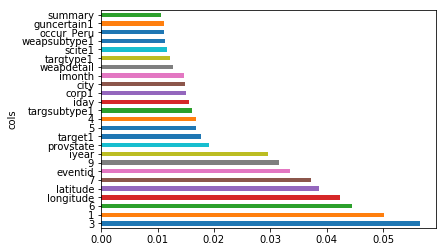

In [27]:
for i in list(X_oh_train.columns):
    i = str(i)
    if(i[len(i)-3:len(i)] == '_na'):
        X_oh_train = X_oh_train.drop(columns=[i])

for i in list(X_oh_valid.columns):
    i = str(i)
    if(i[len(i)-3:len(i)] == '_na'):
        X_oh_valid = X_oh_valid.drop(columns=[i])

model = RandomForestClassifier(n_estimators=25, max_features='sqrt', oob_score=True, n_jobs=-1)
model.fit(X_oh_train, Y_train)
in_sample = model.score(X_oh_train, Y_train)
out_sample = model.score(X_oh_valid, Y_valid)
print([in_sample, out_sample, model.oob_score_])

feat_imp1 = rf_feat_importance(model, X_oh_train)
feat_imp1[:25].plot('cols','imp','barh', legend=False);